# CUSTOMER SEGMENTATION

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import sklearn.cluster as cluster
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
import seaborn as sns

In [2]:
import sklearn.cluster as cluster
from sklearn.cluster import KMeans

In [5]:
retail_df = pd.read_excel("Online Retail.xlsx")
retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
retail_uk = retail_df[retail_df['Country']=='United Kingdom']
#check the shape
retail_uk.shape

(495478, 8)

In [5]:
#remove canceled orders
retail_uk = retail_uk[retail_uk['Quantity']>0]
retail_uk.shape

(486286, 8)

In [6]:
#remove rows where customerID are NA
retail_uk.dropna(subset=['CustomerID'],how='all',inplace=True)
retail_uk.shape

(354345, 8)

# RFM Analysis

RECENCY (R): Days since last purchase

In [7]:
#Choose a date point from which we evaluate how many days ago was the customer's last purchase.

In [8]:
#last date available in our dataset
retail_uk['InvoiceDate'].max()

Timestamp('2011-12-09 12:49:00')

In [9]:
now = dt.date(2011,12,9)
print(now)

2011-12-09


In [10]:
#create a new column called date which contains the date of invoice only
retail_uk['date'] = retail_uk['InvoiceDate'].dt.date

In [11]:
retail_uk.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01


In [18]:
#group by customers and check last date of purchase
recency_df = retail_uk.groupby(by='CustomerID', as_index=False)['date'].max()
recency_df.columns = ['CustomerID','LastPurchaseDate']
recency_df.head()

,CustomerID,LastPurchaseDate
0,12346.0,2011-01-18
1,12747.0,2011-12-07
2,12748.0,2011-12-09
3,12749.0,2011-12-06
4,12820.0,2011-12-06


In [19]:
#calculate recency
recency_df['Recency'] = recency_df['LastPurchaseDate'].apply(lambda x: (now - x).days)
recency_df.head()

,CustomerID,LastPurchaseDate,Recency
0,12346.0,2011-01-18,325
1,12747.0,2011-12-07,2
2,12748.0,2011-12-09,0
3,12749.0,2011-12-06,3
4,12820.0,2011-12-06,3


In [20]:
#drop LastPurchaseDate as we don't need it anymore
recency_df.drop('LastPurchaseDate',axis=1,inplace=True)

Frequency : How many times a customer purchased from us

In [57]:
# drop duplicates
retail_uk_copy = retail_uk
retail_uk_copy.drop_duplicates(subset=['InvoiceNo', 'CustomerID'], keep="first", inplace=True)

In [58]:
frequency_df = retail_uk_copy.groupby(by=['CustomerID'], as_index=False)['InvoiceNo'].count()
frequency_df.columns = ['CustomerID','Frequency']
frequency_df.head()

,CustomerID,Frequency
0,12346.0,1
1,12747.0,11
2,12748.0,210
3,12749.0,5
4,12820.0,4


In [23]:
#create column total cost
retail_uk['TotalCost'] = retail_uk['Quantity'] * retail_uk['UnitPrice']

Monetary Value – How much do they spend?

In [24]:
monetary_df = retail_uk.groupby(by='CustomerID',as_index=False).agg({'TotalCost': 'sum'})
monetary_df.columns = ['CustomerID','Monetary']
monetary_df.head()

,CustomerID,Monetary
0,12346.0,77183.60
1,12747.0,689.49
2,12748.0,3841.31
3,12749.0,98.35
4,12820.0,58.20


In [25]:
#merge recency dataframe with frequency dataframe
temp_df = recency_df.merge(frequency_df,on='CustomerID')
temp_df.head()

,CustomerID,Recency,Frequency
0,12346.0,325,1
1,12747.0,2,11
2,12748.0,0,210
3,12749.0,3,5
4,12820.0,3,4


Applying RFM score formula

In [26]:
#Merge with monetary dataframe
df_rfm = temp_df.merge(monetary_df,on='CustomerID')
df_rfm.set_index('CustomerID',inplace=True)
df_rfm.head()

,Recency,Frequency,Monetary
CustomerID,,,
12346.0,325,1,77183.60
12747.0,2,11,689.49
12748.0,0,210,3841.31
12749.0,3,5,98.35
12820.0,3,4,58.20


In [27]:
retail_uk[retail_uk['CustomerID']==12346.0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,date,TotalCost
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,77183.6


In [28]:
(now - dt.date(2011,1,18)).days == 325

True

In [29]:
customers_rank = df_rfm
# Create a new column that is the rank of the value of coverage in ascending order
customers_rank['Rank'] = customers_rank['Monetary'].rank(ascending=0)
#customers_rank.drop('RevenueRank',axis=1,inplace=True)
customers_rank.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,11,689.49,186.0
12748.0,0,210,3841.31,36.0
12749.0,3,5,98.35,1179.0
12820.0,3,4,58.20,1712.5


Create customers segments from RFM Model use Quartiles. We assign a score from 1 to 4 to Recency, Frequency and Monetary. Four is the best/highest value, and one is the lowest/worst value. A final RFM score is calculated simply by combining individual RFM score numbers.

In [30]:
quantiles = df_rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,Recency,Frequency,Monetary,Rank
0.25,17.0,1.0,17.7,981.0
0.50,50.0,2.0,45.4,1961.0
0.75,142.0,5.0,124.5,2924.0


In [31]:
quantiles.to_dict()

{'Frequency': {0.25: 1.0, 0.5: 2.0, 0.75: 5.0},
 'Monetary': {0.25: 17.700000000000003, 0.5: 45.4, 0.75: 124.50000000000001},
 'Rank': {0.25: 981.0, 0.5: 1961.0, 0.75: 2924.0},
 'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 142.0}}

RFM segmentation table

In [36]:
# Arguments (x = value, p = recency, monetary_value, frequency, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
# Arguments (x = value, p = recency, monetary_value, frequency, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [37]:
#Create RFM segmentation table
rfm_segmentation = df_rfm
rfm_segmentation['R_Quartile'] = rfm_segmentation['Recency'].apply(RScore, args=('Recency',quantiles))
rfm_segmentation['F_Quartile'] = rfm_segmentation['Frequency'].apply(FMScore, args=('Frequency',quantiles))
rfm_segmentation['M_Quartile'] = rfm_segmentation['Monetary'].apply(FMScore, args=('Monetary',quantiles))

In [38]:
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile
CustomerID,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4
12747.0,2,11,689.49,186.0,4,4,4
12748.0,0,210,3841.31,36.0,4,4,4
12749.0,3,5,98.35,1179.0,4,3,3
12820.0,3,4,58.20,1712.5,4,3,3


In [39]:
rfm_segmentation['RFM_Score'] = rfm_segmentation.R_Quartile.map(str) \
                            + rfm_segmentation.F_Quartile.map(str) \
                            + rfm_segmentation.M_Quartile.map(str)
rfm_segmentation.head()

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,,
12346.0,325,1,77183.60,2.0,1,1,4,114
12747.0,2,11,689.49,186.0,4,4,4,444
12748.0,0,210,3841.31,36.0,4,4,4,444
12749.0,3,5,98.35,1179.0,4,3,3,433
12820.0,3,4,58.20,1712.5,4,3,3,433


In [40]:
#Best Customers ( BEST RMF SCORES)

In [41]:
rfm_segmentation[rfm_segmentation['RFM_Score']=='444'].sort_values('Monetary', ascending=False).head(10)

,Recency,Frequency,Monetary,Rank,R_Quartile,F_Quartile,M_Quartile,RFM_Score
CustomerID,,,,,,,,
18102.0,0,60,42053.60,3.0,4,4,4,444
17949.0,1,45,29999.69,5.0,4,4,4,444
17450.0,8,46,26768.97,6.0,4,4,4,444
16013.0,3,47,17895.28,8.0,4,4,4,444
16333.0,7,22,14418.96,9.0,4,4,4,444
15769.0,7,26,11752.64,11.0,4,4,4,444
12901.0,8,28,9230.45,12.0,4,4,4,444
13798.0,1,57,8194.26,13.0,4,4,4,444
16684.0,4,28,7700.08,14.0,4,4,4,444


In [42]:
print("Best Customers: ",len(rfm_segmentation[rfm_segmentation['RFM_Score']=='444']))
print('Loyal Customers: ',len(rfm_segmentation[rfm_segmentation['F_Quartile']==4]))
print("Big Spenders: ",len(rfm_segmentation[rfm_segmentation['M_Quartile']==4]))
print('Almost Lost: ', len(rfm_segmentation[rfm_segmentation['RFM_Score']=='244']))
print('Lost Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='144']))
print('Lost Cheap Customers: ',len(rfm_segmentation[rfm_segmentation['RFM_Score']=='111']))

Best Customers:  370
Loyal Customers:  791
Big Spenders:  980
Almost Lost:  65
Lost Customers:  11
Lost Cheap Customers:  377


# APPLY K_MEANS CLUSTERING

In [43]:
#Preprocess
rfm_data = df_rfm.drop(['R_Quartile','F_Quartile','M_Quartile','RFM_Score'],axis=1)
rfm_data.head()

,Recency,Frequency,Monetary,Rank
CustomerID,,,,
12346.0,325,1,77183.60,2.0
12747.0,2,11,689.49,186.0
12748.0,0,210,3841.31,36.0
12749.0,3,5,98.35,1179.0
12820.0,3,4,58.20,1712.5


In [44]:
rfm_data.corr()

,Recency,Frequency,Monetary,Rank
Recency,1.000000,-0.273779,-0.030123,0.323782
Frequency,-0.273779,1.000000,0.163225,-0.456873
Monetary,-0.030123,0.163225,1.000000,-0.132923
Rank,0.323782,-0.456873,-0.132923,1.000000


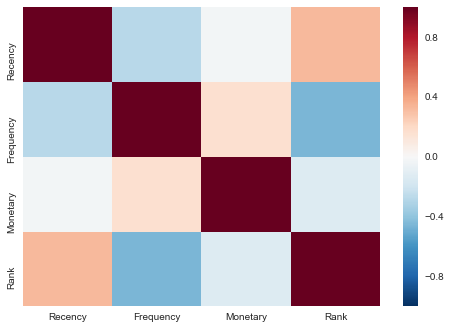

In [45]:
sns.heatmap(rfm_data.corr())

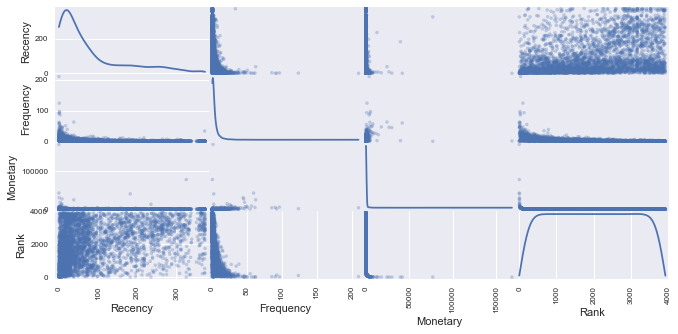

In [46]:
# Produce a scatter matrix for each pair of features in the data
scatter_matrix(rfm_data, alpha = 0.3, figsize = (11,5), diagonal = 'kde');

In [47]:
#Data Normalization

In [48]:
#log transformation
rfm_r_log = np.log(rfm_data['Recency']+0.1)
rfm_f_log = np.log(rfm_data['Frequency'])
rfm_m_log = np.log(rfm_data['Monetary']+0.1)

In [59]:
log_data = pd.DataFrame({'Monetary': rfm_m_log,'Recency': rfm_r_log,'Frequency': rfm_f_log})

In [50]:
log_data.corr()

,Frequency,Monetary,Recency
Frequency,1.000000,0.716935,-0.573982
Monetary,0.716935,1.000000,-0.368472
Recency,-0.573982,-0.368472,1.000000


In [65]:
matrix = log_data.as_matrix()
for n_clusters in range(2,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)

In [71]:
n_clusters = 2
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
kmeans.fit(matrix)
clusters_customers = kmeans.predict(matrix)

Text(0,0.5,'Frequency')

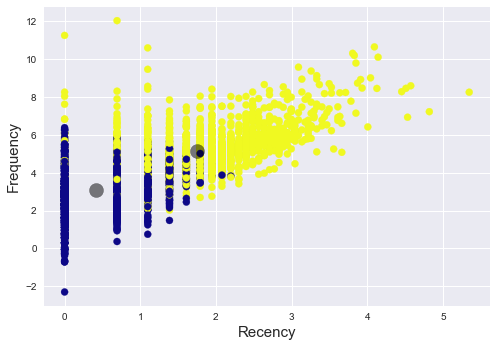

In [72]:
#create a scatter plot
plt.scatter(matrix[:, 0], matrix[:, 1], c=clusters_customers, s=50, cmap='plasma')
#select cluster centers
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.xlabel('Recency', fontsize=15)
plt.ylabel('Frequency', fontsize=15)

The yellow cluster has a centroid represents the "low value customers". The dark blue cluster has a centroid represents the "high value customers".

In [73]:
# What's the number of customers in each cluster?
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['NumberCustomers']).T

,0,1
NumberCustomers,2360,1561
